In [1]:
import json
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import cv2

## Load Pandas Dataframe

In [2]:
albums_df = pd.read_pickle("./albums_df_s1.pkl")

### Feature Vectors 

The available feature descriptors are:

- `has_face` that indicates if a **face** is present in the album cover
- `hog_descriptor` that quantifies the **structure** of the image 
- `hsv_hist` that quantifies the **color** of the image
- `lbp_hist` that quantifies the **texture** of the image

### Combining Feature Vectors 

For global feature vectors, we concatenate each feature vector to form a single global feature vector. This approach used in this notebook.


In [3]:
fv_has_face = albums_df.has_face
fv_hog_desc = albums_df.hog_descriptor
fv_hsv_hist = albums_df.hsv_hist
fv_lbp_hist = albums_df.lbp_hist

In [4]:
from sklearn.preprocessing import StandardScaler,MinMaxScaler

global_feature =[]

for index in albums_df.index:
    feature_vector = np.hstack([fv_hog_desc[index], fv_hsv_hist[index]])
    global_feature.append(feature_vector)
    
# scaler = MinMaxScaler(feature_range=(0, 1))    
# X = scaler.fit_transform(global_feature)

albums_df['X'] = global_feature

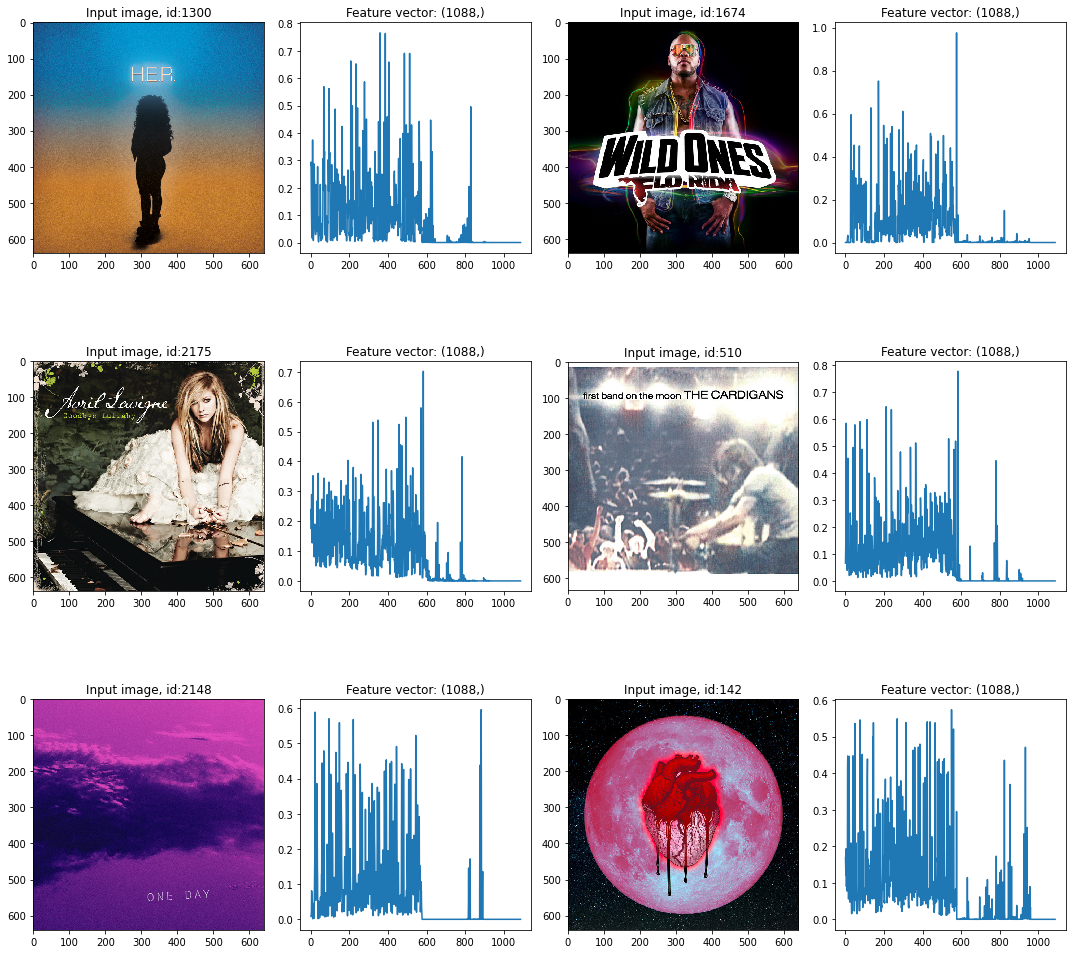

In [5]:
from skimage.io import imread, imshow

image_samples = albums_df.filepath.sample(n = 6, random_state = 42) 
fig = plt.figure(figsize=(15, 15))

columns = 4
rows = 3
hog_no = 0

for plot_number, filepath in enumerate(image_samples):
    image = imread(filepath)
     
    
    ax1 = fig.add_subplot(rows, columns, plot_number+hog_no+1,)
    imshow(image )
    ax1.set_title(f'Input image, id:{albums_df[albums_df.filepath == filepath].index[0]}') 
    
    ax2 = fig.add_subplot(rows, columns, plot_number+hog_no+2,)
    plt.plot(albums_df[albums_df.filepath == filepath].X.values[0])
    asp = np.diff(ax2.get_xlim())[0] / np.diff(ax2.get_ylim())[0]
    ax2.set_aspect(asp)
    ax2.set_title(f"Feature vector: ({albums_df[albums_df.filepath == filepath].X.values[0].size},)")
    
    hog_no+=1
    
plt.show()

## Split the Dataset

The `train_test_split` function provided by `scikit-learn` is used to split the dataset into training and testing data. 

The model will be trained using the training dataset. The split size is decided by the `test_size` parameter, in our case:

- 80% Train Data 
- 20% Test Data

The `stratify` parameter is also used to ensure better class distributions in the training and test set.

In [6]:
from sklearn.model_selection import train_test_split

X = albums_df.X 
y = np.array([genre[0] for genre in albums_df.genres], dtype='object')

X_train, X_test, y_train, y_test = train_test_split(
    X, 
    y, 
    test_size=0.2, 
    shuffle=True,
    random_state=22,
    stratify=y
)

In [7]:
def transform(X):
    return np.array([x for x in X] )

X_train_prepared = transform(X_train)
X_test_prepared = transform(X_test)

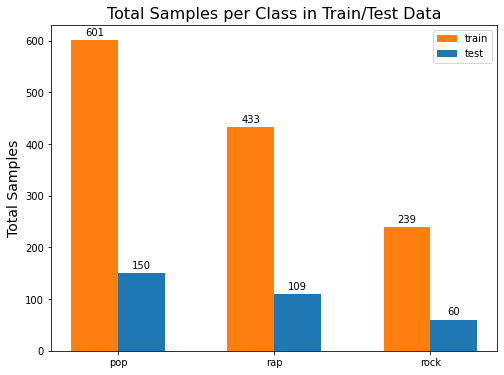

In [8]:
fig, (ax) = plt.subplots(1,1,figsize=(8,6))

labels = ['pop', 'rap', 'rock']
train = list(np.unique(y_train, return_counts=True)[1])
test = list(np.unique(y_test, return_counts=True)[1])

x = np.arange(len(labels))
width = 0.3 

rects1 = ax.bar(x - width/2, train, width, label='train', color = '#ff7f0e')
rects2 = ax.bar(x + width/2, test, width, label='test', color = '#1f77b4')

def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)

ax.set_ylabel('Total Samples', size = 14)
ax.set_title('Total Samples per Class in Train/Test Data', size = 16)
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

The distributions are not equal, considering the low number of sample for both rap and rock classes. 

It is **important to balance the ditributions** with adding more data for those classes.

## Cross Validation

Our dataset does not have a decent size to also build a separate validation set to tune the various hyperparameters. 

For this reason, we use the **K-Fold Cross Validation** technique on the training dataset to simulate a validation set.

We choose K = 10, then we split the training data into 9 parts for training and 1 part for testing uniquely over each round upto 10 times. Each model is then trained and evaluated for a given performance metric. Then the 10 values of the chosen metric are averaged to get the final value.

The `StratifiedKFold` method is used. This is a variation of KFold that returns stratified folds. The folds are made by preserving the percentage of samples for each class.

The following models from `sklearn` are used:

- LogisticRegression
- RandomForestClassifier
- KNeighborsClassifier
- SVM

In [14]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from skimage.io import imread, imshow

In [171]:
random_seed = 22
num_trees = 100
scoring = "accuracy"

models = []
models.append(('LR', LogisticRegression(random_state=random_seed, max_iter = 1000)))
models.append(('RF', RandomForestClassifier(n_estimators=num_trees, random_state=random_seed)))
models.append(('KNN', KNeighborsClassifier()))
models.append(('SVM', SVC(random_state=random_seed)))

In [172]:
results = []
names   = []

for name, model in models:
    kfold = StratifiedKFold(n_splits=10, random_state=random_seed, shuffle=True)
    cv_results = cross_val_score(model, X_train_prepared, y_train, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = f"{name}: {cv_results.mean():.2f} ({cv_results.std():.2f})"
    print(msg)

LR: 0.44 (0.03)
RF: 0.50 (0.02)
KNN: 0.43 (0.04)
SVM: 0.48 (0.02)


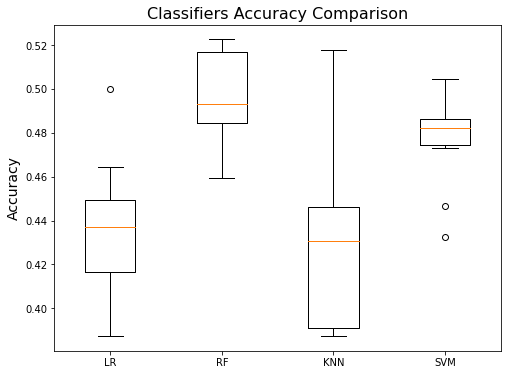

In [173]:
fig, (ax) = plt.subplots(1,1,figsize=(8,6))

plt.boxplot(results)

ax.set_title('Classifiers Accuracy Comparison', size = 16)
ax.set_ylabel('Accuracy', size = 14)
ax.set_xticklabels(names)
plt.show()

## Hyperparameters Tuning

As a tuning technique we use **Grid Search**. For each algorithm we define a different set of hyperparameters to tune, and use the training to train one model for each possible combination of hyperparameters. The performance of each model is assessed, using K-Fold cross validation.

Based on the previous results, we choose the following models to tune:

- RandomForestClassifier
- SVM

In [10]:
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

### Random Forest Classifier

The following parameters are tuned:

- number of random features to sample at each split point. Try a range of integer values random, or 1 to half the number of   input features. Try also a suite of different default value calculators.

  **max_features** : `sqrt`, `log2`


- the number of trees 

  **n_estimators** : `10`, `100`, `1000`

In [180]:
model = RandomForestClassifier()

n_estimators = [10, 100, 1000]
max_features = ['sqrt', 'log2']

grid = dict(n_estimators=n_estimators,max_features=max_features)

cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)

grid_search = GridSearchCV(estimator=model, 
                           param_grid=grid, 
                           n_jobs=-1, 
                           cv=cv, 
                           scoring='accuracy',
                           error_score=0)

grid_result = grid_search.fit(X_train_prepared, y_train)

# Results
print('-'*65)
print(f"BEST: {grid_result.best_score_:.2f}, params: {grid_result.best_params_}")
print('-'*65)

means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']

for mean, stdev, param in zip(means, stds, params):
    print(f"{mean:.2f} ({stdev:.2f}), params: {param}")

-----------------------------------------------------------------
BEST: 0.49, params: {'max_features': 'log2', 'n_estimators': 1000}
-----------------------------------------------------------------
0.45 (0.03), params: {'max_features': 'sqrt', 'n_estimators': 10}
0.49 (0.03), params: {'max_features': 'sqrt', 'n_estimators': 100}
0.49 (0.02), params: {'max_features': 'sqrt', 'n_estimators': 1000}
0.46 (0.04), params: {'max_features': 'log2', 'n_estimators': 10}
0.49 (0.03), params: {'max_features': 'log2', 'n_estimators': 100}
0.49 (0.02), params: {'max_features': 'log2', 'n_estimators': 1000}


### SVM

The following parameters are tuned:

- the kernel that controls the manner in which the input variables will be projected. 
  
  **kernel** : `poly`, `rbf`, `sigmoid`


- the penalty C that affects the shape of the resulting regions for each class.

   **C** : `0.001`, `0.1`, `1.0`, `10`, `100`


In [135]:
model = SVC()

kernel = ['poly', 'rbf', 'sigmoid']
C = [0.001, 0.1, 1.0, 10, 100]
gamma = ['scale']

grid = dict(kernel=kernel,C=C,gamma=gamma)

cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)

grid_search = GridSearchCV(estimator=model, 
                           param_grid=grid, 
                           n_jobs=-1, 
                           cv=cv, 
                           scoring='accuracy',
                           error_score=0)

grid_result = grid_search.fit(X_train_prepared, y_train)

# Results
print('-'*65)
print(f"BEST: {grid_result.best_score_:.2f}, params: {grid_result.best_params_}")
print('-'*65)

means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']

for mean, stdev, param in zip(means, stds, params):
    print(f"{mean:.2f} ({stdev:.2f}), params: {param}")

-----------------------------------------------------------------
BEST: 0.47, params: {'C': 0.001, 'gamma': 'scale', 'kernel': 'poly'}
-----------------------------------------------------------------
0.47 (0.00), params: {'C': 0.001, 'gamma': 'scale', 'kernel': 'poly'}
0.47 (0.00), params: {'C': 0.001, 'gamma': 'scale', 'kernel': 'rbf'}
0.47 (0.00), params: {'C': 0.001, 'gamma': 'scale', 'kernel': 'sigmoid'}
0.44 (0.02), params: {'C': 0.1, 'gamma': 'scale', 'kernel': 'poly'}
0.47 (0.00), params: {'C': 0.1, 'gamma': 'scale', 'kernel': 'rbf'}
0.47 (0.00), params: {'C': 0.1, 'gamma': 'scale', 'kernel': 'sigmoid'}
0.45 (0.04), params: {'C': 1.0, 'gamma': 'scale', 'kernel': 'poly'}
0.46 (0.02), params: {'C': 1.0, 'gamma': 'scale', 'kernel': 'rbf'}
0.45 (0.02), params: {'C': 1.0, 'gamma': 'scale', 'kernel': 'sigmoid'}
0.42 (0.05), params: {'C': 10, 'gamma': 'scale', 'kernel': 'poly'}
0.46 (0.04), params: {'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}
0.39 (0.05), params: {'C': 10, 'gamma': 's

## Model Evaluation

Unfortunately the accuracy of our models is not acceptable and further optimization steps should be performed. *(please check Next Steps section)*

For the next steps, we choose to evaluate the Random Forest Classifier model.


BEST: 0.49, params: {'max_features': 'log2', 'n_estimators': 1000}

### Train Model

In [12]:
random_seed = 22

clf = RandomForestClassifier(n_estimators=1000,
                             max_features='log2',
                             random_state=random_seed).fit(X_train_prepared, y_train)

In [230]:
random_seed = 22

clf = SVC(C=0.001,
          gamma='scale', 
          kernel='poly',
          random_state=seed).fit(X_train_prepared, y_train)

### Training Set Performance

The training set performance is a strong indicator that our model **overfits** the training dataset.

In [15]:
y_pred = clf.predict(X_train_prepared)

print(classification_report(y_train, y_pred, target_names=['pop', 'rap', 'rock']))

              precision    recall  f1-score   support

         pop       1.00      1.00      1.00       601
         rap       1.00      1.00      1.00       433
        rock       1.00      1.00      1.00       239

    accuracy                           1.00      1273
   macro avg       1.00      1.00      1.00      1273
weighted avg       1.00      1.00      1.00      1273



### Test Set Performance

The model is able to predict albums from the pop genre with a F1-Score of 0.65.

In [16]:
y_pred = clf.predict(X_test_prepared)

print(classification_report(y_test, y_pred, target_names=['pop', 'rap', 'rock']))

              precision    recall  f1-score   support

         pop       0.50      0.95      0.65       150
         rap       0.67      0.20      0.31       109
        rock       1.00      0.02      0.03        60

    accuracy                           0.52       319
   macro avg       0.72      0.39      0.33       319
weighted avg       0.65      0.52      0.42       319



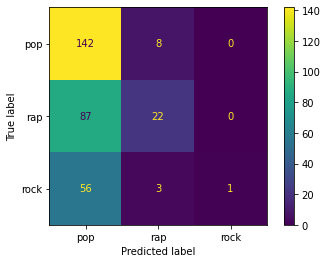

In [17]:
from sklearn.metrics import plot_confusion_matrix

plot_confusion_matrix(clf, X_test_prepared, y_test)  
plt.show() 

## Plot Predictions

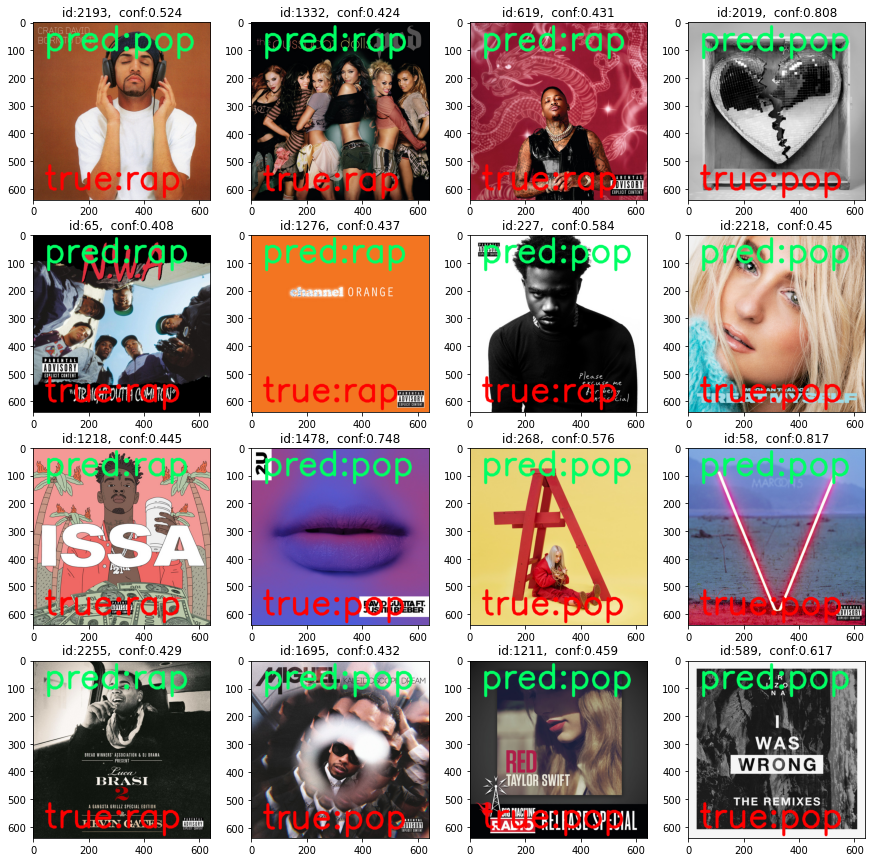

In [241]:
from skimage.io import imread, imshow

fig = plt.figure(figsize=(15, 15))

columns = 4
rows = 4

for i in range(16):
    
    index = X_test.sample().index[0]

    filepath = albums_df.filepath[index]
    image = cv2.imread(filepath)
    
    prediction = pd.Series(clf.predict_proba([X_test[index]]).tolist().pop(), ['pop','rap', 'rock'])

    cv2.putText(image, "pred:" + prediction.idxmax() , (40,100), cv2.FONT_HERSHEY_SIMPLEX, 4.0, (100,255,0), 9)
    cv2.putText(image, "true:" + albums_df.genres[index][0], (40,600), cv2.FONT_HERSHEY_SIMPLEX, 4.0, (0,0,255), 9)
    
    ax1 = fig.add_subplot(rows, columns, i + 1,)
    ax1.set_title(f"id:{index},  conf:{prediction.max()}")
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))  

plt.show()

## Plot Predictions using custom images

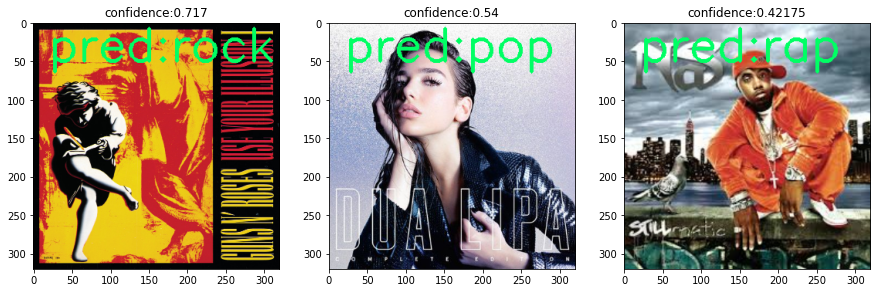

In [18]:
from fd_functions import fd_hog_descriptor, fd_hsv_histogram, fd_local_binary_pattern

filepaths = ['.\\other\\rock2.jpg', '.\\other\\pop1.jpg', '.\\other\\rap1.jpg'  ]
 
fig = plt.figure(figsize=(15, 15))

columns = 3
rows = 1

for i in range(3):
    
    filepath = filepaths[i]
   
    image = imread(filepath)
    fv_1 = fd_hog_descriptor(image)
       
    image = cv2.imread(filepath)
    fv_2 = fd_hsv_histogram(image)
    
    image = cv2.imread(filepath)
    resized = cv2.resize(image, (320,320))
 
    X = np.array(np.append(fv_1,fv_2 ))

    prediction = pd.Series(clf.predict_proba([X]).tolist().pop(), ['pop','rap', 'rock'])

    cv2.putText(resized, "pred:" + prediction.idxmax() , (20,50), cv2.FONT_HERSHEY_SIMPLEX, 2.0, (100,255,0), 4)
    
    ax1 = fig.add_subplot(rows, columns, i + 1,)
    ax1.set_title(f"confidence:{prediction.max()}")
    plt.imshow(cv2.cvtColor(resized, cv2.COLOR_BGR2RGB))  

plt.show()